In [1]:
!pip install ptan

     |████████████████████████████████| 773.1MB 21kB/s 
  Created wheel for ptan: filename=ptan-0.6-cp36-none-any.whl size=23502 sha256=04cd8c9bade1bc718b15f6b5c6ceabfda4c9367b566f73c424fed0320ae8702e
  Stored in directory: /root/.cache/pip/wheels/f0/4b/2f/9a45fd39b0a614a2716bc6128a7f1adb4647f323a2d90783f2
Successfully built ptan
ERROR: torchvision 0.8.1+cu101 has requirement torch==1.7.0, but you'll have torch 1.3.0 which is incompatible.
  Found existing installation: torch 1.7.0+cu101
    Uninstalling torch-1.7.0+cu101:
      Successfully uninstalled torch-1.7.0+cu101


In [2]:
import gym
import ptan
import numpy as np
import argparse
#from tensorboardX import SummaryWriter

import torch
import torch.nn as nn
import torch.nn.utils as nn_utils
import torch.nn.functional as F
import torch.optim as optim

#from lib import common

In [3]:
GAMMA = 0.99
LEARNING_RATE = 0.001
ENTROPY_BETA = 0.01
BATCH_SIZE = 8

REWARD_STEPS = 10
CLIP_GRAD = 0.1

In [4]:
class A2C(nn.Module):
    def __init__(self, input_size, n_actions):
        super(A2C, self).__init__()

        self.policy = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )

        self.value = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.policy(x), self.value(x)

In [5]:
def unpack_batch(batch, net, device='cpu'):
    """
    Convert batch into training tensors
    :param batch:
    :param net:
    :return: states variable, actions tensor, reference values variable
    """
    states = []
    actions = []
    rewards = []
    not_done_idx = []
    last_states = []
    for idx, exp in enumerate(batch):
        states.append(np.array(exp.state, copy=False))
        actions.append(int(exp.action))
        rewards.append(exp.reward)
        if exp.last_state is not None:
            not_done_idx.append(idx)
            last_states.append(np.array(exp.last_state, copy=False))

    states_v = torch.FloatTensor(
        np.array(states, copy=False)).to(device)
    actions_t = torch.LongTensor(actions).to(device)

    # handle rewards
    rewards_np = np.array(rewards, dtype=np.float32)
    if not_done_idx:
        last_states_v = torch.FloatTensor(np.array(last_states, copy=False)).to(device)
        last_vals_v = net(last_states_v)[1]
        last_vals_np = last_vals_v.data.cpu().numpy()[:, 0]
        last_vals_np *= GAMMA ** REWARD_STEPS
        rewards_np[not_done_idx] += last_vals_np

    ref_vals_v = torch.FloatTensor(rewards_np).to(device)

    return states_v, actions_t, ref_vals_v



In [6]:
if __name__ == "__main__":

    device = 'cuda'
    env = gym.make("CartPole-v0")

    obs_size = env.observation_space.shape[0]
    n_actions = env.action_space.n

    net = A2C(obs_size, n_actions).to(device)
    print(net)

    agent = ptan.agent.PolicyAgent(lambda x: net(x)[0], preprocessor=ptan.agent.float32_preprocessor,
        apply_softmax=True, device=device)
    exp_source = ptan.experience.ExperienceSourceFirstLast(
        env, agent, gamma=GAMMA, steps_count=REWARD_STEPS)

    optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATE, eps=1e-3)

    batch = []
    
    total_rewards = []
    step_rewards = []
    step_idx = 0
    done_episodes = 0
    reward_sum = 0.0
    
    for step_idx, exp in enumerate(exp_source):
        
        #print(step_idx)
        batch.append(exp)
                
        # handle new rewards
        new_rewards = exp_source.pop_total_rewards()
        if new_rewards:
            done_episodes += 1
            reward = new_rewards[0]
            total_rewards.append(reward)
            mean_rewards = float(np.mean(total_rewards[-100:]))
            print("%d: reward: %6.2f, mean_100: %6.2f, episodes: %d" % (
                step_idx, reward, mean_rewards, done_episodes))
            if mean_rewards > 195:
                print("Solved in %d steps and %d episodes!" % (step_idx, done_episodes))
                break

        if len(batch) < BATCH_SIZE:
            continue

        states_v, actions_t, vals_ref_v = unpack_batch(batch, net, device=device)
        batch.clear()

        optimizer.zero_grad()
        logits_v, value_v = net(states_v)
        loss_value_v = F.mse_loss(value_v.squeeze(-1), vals_ref_v)

        log_prob_v = F.log_softmax(logits_v, dim=1)
        adv_v = vals_ref_v - value_v.detach()
        log_prob_actions_v = adv_v * log_prob_v[range(BATCH_SIZE), actions_t]
        loss_policy_v = -log_prob_actions_v.mean()

        prob_v = F.softmax(logits_v, dim=1)
        entropy_loss_v = ENTROPY_BETA * (prob_v * log_prob_v).sum(dim=1).mean()

        # calculate policy gradients only
        loss_policy_v.backward(retain_graph=True)
        grads = np.concatenate([p.grad.data.cpu().numpy().flatten()
                        for p in net.parameters()
                        if p.grad is not None])

        # apply entropy and value gradients
        loss_v = entropy_loss_v + loss_value_v
        loss_v.backward()
        #nn_utils.clip_grad_norm_(net.parameters(), CLIP_GRAD)
        optimizer.step()
        # get full loss
        loss_v += loss_policy_v

        #tb_tracker.track("advantage",       adv_v, step_idx)
        #tb_tracker.track("values",          value_v, step_idx)
        #tb_tracker.track("batch_rewards",   vals_ref_v, step_idx)
        #tb_tracker.track("loss_entropy",    entropy_loss_v, step_idx)
        #tb_tracker.track("loss_policy",     loss_policy_v, step_idx)
        #tb_tracker.track("loss_value",      loss_value_v, step_idx)
        #tb_tracker.track("loss_total",      loss_v, step_idx)
        #tb_tracker.track("grad_l2",         np.sqrt(np.mean(np.square(grads))), step_idx)
        #tb_tracker.track("grad_max",        np.max(np.abs(grads)), step_idx)
        #tb_tracker.track("grad_var",        np.var(grads), step_idx)

A2C(
  (policy): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=2, bias=True)
  )
  (value): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=1, bias=True)
  )
)
19: reward:  19.00, mean_100:  19.00, episodes: 1
56: reward:  37.00, mean_100:  28.00, episodes: 2
86: reward:  30.00, mean_100:  28.67, episodes: 3
100: reward:  14.00, mean_100:  25.00, episodes: 4
116: reward:  16.00, mean_100:  23.20, episodes: 5
146: reward:  30.00, mean_100:  24.33, episodes: 6
169: reward:  23.00, mean_100:  24.14, episodes: 7
189: reward:  20.00, mean_100:  23.62, episodes: 8
254: reward:  65.00, mean_100:  28.22, episodes: 9
273: reward:  19.00, mean_100:  27.30, episodes: 10
291: reward:  18.00, mean_100:  26.45, episodes: 11
321: reward:  30.00, mean_100:  26.75, episodes: 12
356: reward:  35.00, mean_100:  27.38, episodes: 13
37

In [7]:
import sys
IN_COLAB = 'google.colab' in sys.modules
if(IN_COLAB):
    !apt update
    !apt install xvfb
    !pip install gym-notebook-wrapper
    import gnwrapper

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:5 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:6 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:7 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:8 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:9 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:11 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:12 http://security.ubuntu.com/ub

Total score: 200.0


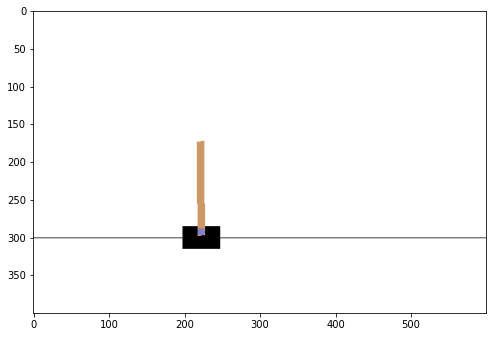

In [8]:
import numpy as np

#env = gnwrapper.Monitor(gym.make('CartPole-v0'), directory="./") # Start Xvfb
#env = gnwrapper.Animation(gym.make('CartPole-v0')) # Start Xvfb
env = gnwrapper.LoopAnimation(gym.make('CartPole-v0')) # Start Xvfb

# See our trained network in action
observation = env.reset()
reward_sum = 0
done =  False
while not done:
    env.render()
    x = np.reshape(observation, [1, obs_size])
    x_torch = torch.FloatTensor(x).to(device)
    P, Q = net(x_torch)
    action = np.argmax(P.detach().cpu().numpy())

    observation, reward, done, _ = env.step(action)
    reward_sum += reward

print("Total score: {}".format(reward_sum))
env.display() # Display saved display images as animation

In [9]:
env.close()